In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# Add a constant to the model (intercept)
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.linear_model import LogisticRegression

In [2]:
dealer_data = pd.read_csv('dealer/dealer_data.csv')

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (75,76,77,78,79,105,106,122,123,128,130,132,134,171,172,178,189) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# Define the columns needed based on your list for predicting 'PrimaryDealer'
columns_needed = [
    # General columns
    'Date', 'DealCSP', "RR_Price",
    # Trade chain
    'TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10',
    # Probability prediction
    "PrimaryDealer", "HHI_number", "TradeSize", "TimeToMaturity", "TimeSinceOffering",
    "Seniority", "Offering_amount", "Rating", "JunkDummy", "UnratedDummy", "Enhanced", 
    "Redeemable", "SinkingFund", "BOND_COUPON", "IQ_CDS_availability", "COVENANTS",
    "Year", "AvgTransVol", "TRADES_VOL", "amihud_ILLIQ_trades", "price_dispersion_volumeweighted",
    "EquityValue", "DefaultBarrier2", "NumberEmployees", "IndDis1", "IndDis2",
    "Slope", "X90DayDR", "GDP", "Default"
]

# Limit the DataFrame to the relevant columns
dealer_df_limited = dealer_data[columns_needed]

# rename DealCSP to CUSIP
dealer_df_limited.rename(columns={'DealCSP': 'CUSIP'}, inplace=True)

# rename RR_price to dealer_RR
dealer_df_limited.rename(columns={'RR_Price': 'dealer_RR'}, inplace=True)

# transform the date column to date
dealer_df_limited['Date'] = pd.to_datetime(dealer_df_limited['Date'])

# ingore time
dealer_df_limited['Date'] = dealer_df_limited['Date'].dt.date

/Users/constantinernstberger/opt/anaconda3/envs/aiss/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_76963/2063043269.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dealer_df_limited['Date'] = pd.to_datetime(dealer_df_limited['Date'])
/var/folders/jx/r9zzxsjd7wxgmmn32r0l8cz40000gn/T/ipykernel_76963/2063043269.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [4]:
# Convert categorical columns to dummy variables
categorical_cols = ["TradeSize", "Seniority", "Default"]
dealer_df_limited = pd.get_dummies(dealer_df_limited, columns=categorical_cols, drop_first=True)

# Ensure numeric columns are of float type
numeric_cols = ["HHI_number", "TimeToMaturity", "TimeSinceOffering", "Offering_amount", 
                "BOND_COUPON", "IQ_CDS_availability", "COVENANTS", "AvgTransVol", "TRADES_VOL", 
                "amihud_ILLIQ_trades", "price_dispersion_volumeweighted", "EquityValue", 
                "DefaultBarrier2", "NumberEmployees", "IndDis1", "IndDis2", "Slope", 
                "X90DayDR", "GDP"]
dealer_df_limited[numeric_cols] = dealer_df_limited[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [5]:
presentation_analysis = pd.read_csv('transcripts/LLM_outputs_presentation.csv')
qna_analysis = pd.read_csv('transcripts/LLM_QnA_analysis.csv')

# Add GoEmotions labels to the llm_output
emotions_presentation = pd.read_csv('goemotions/presentation_summary_final.csv', delimiter='|')
emotions_qna = pd.read_csv('goemotions/qna_summary_final.csv', delimiter='|')
emotions_analysts = pd.read_csv('goemotions/analysts_summary_final.csv', delimiter='|')

presentation_labels = ['negative_sentiment', 'positive_sentiment', 'uncertainty', 'optimistic', 'pessimistic', 'vagueness', 'language_accessibility_presentation',
              'liquidity_position', 'debt_leverage_stress', 'operational_trends', 'industry_positioning', 'asset_quality', 'recovery_strategies', 'legal_issues','macroeconomic']

qna_labels = ['analyst_concerns', 'responsiveness', 'confidence', 'evasiveness', 'depth', 'analyst_satisfaction', 'language_accessibility_qna']

qna_mgmt = ['responsiveness', 'confidence', 'depth', 'evasiveness', 'language_accessibility_qna']
qna_analysts = ['analyst_concerns', 'analyst_satisfaction']

emotions = [
        'admiration', 
        #'amusement', 
        'anger', 
        'annoyance', 
        'approval', 
        'caring', 
        'confusion', 
        'curiosity', 
        'desire',
        'disappointment', 
        'disapproval', 
        #'disgust', 
        'embarrassment', 
        'excitement', 
        'fear', 
        #'gratitude', 
        #'grief',
        'joy', 
        #'love', 
        'nervousness', 
        'optimism', 
        'pride', 
        'realization', 
        'relief', 
        'remorse', 
        'sadness', 
        'surprise'
    ]

analyst_emotions = []
for i in emotions:
    analyst_emotions.append(i + '_analysts')

In [6]:
SEPARATE = False

presentation_analysis.rename(columns={'language_accessibility': 'language_accessibility_presentation'}, inplace=True)
qna_analysis.rename(columns={'language_accessibility': 'language_accessibility_qna'}, inplace=True)

qna_analysis = qna_analysis[["call_ID"] + qna_labels]
qna_analysis.drop_duplicates(keep='first', inplace=True)
emotions_presentation = emotions_presentation[["call_ID"] + emotions]
emotions_presentation.drop_duplicates(keep='first', inplace=True)
emotions_qna = emotions_qna[["call_ID"] + emotions]
emotions_qna.drop_duplicates(keep='first', inplace=True)
emotions_analysts = emotions_analysts[["call_ID"] + emotions]
emotions_analysts.drop_duplicates(keep='first', inplace=True)

# add qna_labels to the llm_output
llm_output = pd.merge(presentation_analysis, qna_analysis, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_presentation, on='call_ID', how='left')
llm_output = pd.merge(llm_output, emotions_qna, on='call_ID', how='left')

if not SEPARATE:
    for emotion in emotions:
        llm_output[emotion] = llm_output[f'{emotion}_x'] + llm_output[f'{emotion}_y']
        llm_output.drop([f'{emotion}_x', f'{emotion}_y'], axis=1, inplace=True)
        scaler = MinMaxScaler()
        llm_output[emotion] = scaler.fit_transform(llm_output[[emotion]])

llm_output = pd.merge(llm_output, emotions_analysts, on='call_ID', how='left')

# rename emotions_x to emotions and emotions_y to emotions_analysts
for emotion in emotions:
    llm_output.rename(columns={f'{emotion}_x': f'{emotion}', f'{emotion}_y': f'{emotion}_analysts'}, inplace=True)

llm_output.head()

,RR,ActIndustryDistress1,ActIndustryDistress2,Senior secured,Senior unsecured,Senior subordinated,Subordinated \& Junior,Equity value,Default barrier,Net income margin,...,fear_analysts,joy_analysts,nervousness_analysts,optimism_analysts,pride_analysts,realization_analysts,relief_analysts,remorse_analysts,sadness_analysts,surprise_analysts
0,29.023972,0,1,0,1,0,0,635.12600,0.173560,-0.026785,...,0.000000,0.000000,0.0,0.966905,0.0,0.145973,0.0,0.0,0.0,0.457073
1,8.869420,1,0,0,1,0,0,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.151184,0.0,0.000000,0.0,0.0,0.0,0.000000
2,33.210455,0,0,0,1,0,0,228.77559,0.000000,0.000000,...,0.000000,0.642977,0.0,0.082452,0.0,0.030370,0.0,0.0,0.0,0.607991
3,11.875000,0,0,0,0,1,0,-91.83100,1.053145,-0.375589,...,0.313183,0.000000,0.0,0.230339,0.0,0.164301,0.0,0.0,0.0,0.118028
4,18.340000,0,0,0,1,0,0,-96.67500,0.679972,-0.060670,...,0.000000,0.000000,0.0,0.212880,0.0,0.062939,0.0,0.0,0.0,0.000000


In [74]:
dealer_df = pd.merge(dealer_df_limited, llm_output, on='CUSIP', how='inner')

In [75]:
# transform Date_y to date
dealer_df['Date_y'] = pd.to_datetime(dealer_df['Date_y'])

# drop all rows where Date_x < Date_y
dealer_df = dealer_df[dealer_df['Date_x'] >= dealer_df['Date_y']]

In [76]:
# List of trade chain columns
trade_chain_cols = ['TRADE_CHAIN2', 'TRADE_CHAIN3', 'TRADE_CHAIN4', 'TRADE_CHAIN5', 'TRADE_CHAIN6', 'TRADE_CHAIN7', 'TRADE_CHAIN8', 'TRADE_CHAIN9', 'TRADE_CHAIN10']

# Calculate chain length
dealer_df['transaction_chain_length'] = dealer_df[trade_chain_cols].notna().sum(axis=1) + 1  # +1 for the initial trade

In [77]:
# export the data
dealer_df.to_csv('dealer/dealer_data_llm_output.csv', index=False)

In [10]:
supporting_features_1 = [
    'CBOE DJIA Volatility Index',
    'NASDAQ 100 Index return',
    'Manufacturers inventories to sales ratio',
    '30 year conventional mortgage rate',
    'Communication Services', 
    'Consumer Discretionary', 
    'Senior secured',  
    'Time to maturity',  
    'Equity value',
    'CDS availability',
    'ActIndustryDistress1',
    'ActIndustryDistress2',
    'Offering amount',
    'Volume',
    'Industrials','Consumer Staples','Financials','Energy','Health Care','Utilities','Information Technology','Real Estate'
]

supporting_features_2 = [
    'Default barrier',
    'LTDIssuance2',
    'Intangibility',
    'Receivables1',
]

primary_dealer_features = [
    'HHI_number', 'TimeToMaturity', 'TimeSinceOffering', 'Offering_amount',
       'Rating', 'JunkDummy', 'UnratedDummy', 'Enhanced', 'Redeemable',
       'SinkingFund', 'BOND_COUPON', 'IQ_CDS_availability', 'COVENANTS',
        'AvgTransVol', 'TRADES_VOL', 'amihud_ILLIQ_trades',
       'price_dispersion_volumeweighted', 'EquityValue', 'DefaultBarrier2',
       'NumberEmployees', 'IndDis1', 'IndDis2', 'Slope', 'X90DayDR', 'GDP',
       'TradeSize_Retail', 'TradeSize_SmallInstitutional',
       'Seniority_SeniorSubordinate', 'Seniority_SeniorUnsecured',
       'Seniority_SubordinateJunior', 'Default_DefRating',
       'Default_Distressed_exchange', 'Default_Liquidation_C7',
       'Default_RiskRating'
]

In [56]:
def create_colored_chart(model, type):

    # Filter significant features
    significant_features = model.pvalues[model.pvalues < 0.05].index
    importances = model.params[significant_features]  # Only significant features
    importances = importances[1:]

    # Sort importances by their absolute value, and select the top 10
    top_12_importances = importances.abs().sort_values(ascending=False).head(10)
    importances = importances[top_12_importances.index]
    importances = importances.sort_values()  # Sort the values for better visualization

    # Define emotion types (assuming the feature names match these emotion labels)
    emotion_types = {
        'relief': 'positive',
        'remorse': 'negative',
        'nervousness': 'negative',
        'desire': 'positive',
        'fear': 'strong_negative',
        'excitement': 'positive',
        'confusion': 'negative',
        'pride': 'positive',
        'annoyance': 'negative',
        'gratitude': 'positive',
        'anger': 'strong_negative',
        'optimism': 'positive',
        'sadness': 'negative', 
        'approval': 'positive',
        'caring': 'positive',
        'disappointment': 'negative',
        'curiosity': 'positive',
        'surprise': 'positive',
        'admiration': 'positive',
        'embarrassment': 'negative',
        'realization': 'positive',
        'disapproval': 'negative',
        'joy': 'positive',
        'relief_analysts': 'positive',
        'remorse_analysts': 'negative',
        'nervousness_analysts': 'negative',
        'desire_analysts': 'positive',
        'fear_analysts': 'strong_negative',
        'excitement_analysts': 'positive',
        'confusion_analysts': 'negative',
        'pride_analysts': 'positive',
        'annoyance_analysts': 'negative',
        'gratitude_analysts': 'positive',
        'anger_analysts': 'strong_negative',
        'optimism_analysts': 'positive',
        'sadness_analysts': 'negative',
        'approval_analysts': 'positive',
        'caring_analysts': 'positive',
        'disappointment_analysts': 'negative',
        'curiosity_analysts': 'positive',
        'surprise_analysts': 'positive',
        'admiration_analysts': 'positive',
        'embarrassment_analysts': 'negative',
        'realization_analysts': 'positive',
        'disapproval_analysts': 'negative',
        'joy_analysts': 'positive'
    }

    # Map colors to each emotion type
    color_mapping = {
        'positive': 'green',
        'strong_negative': 'red',
        'negative': 'gray',
    }

    # Apply the color mapping to the top 12 significant features
    colors = []
    for feature in importances.index:
        if feature in supporting_features_1 or feature in supporting_features_2 or feature in primary_dealer_features:
            colors.append('blue')
        elif feature in presentation_labels or feature in qna_labels:
            colors.append('orange')
        elif feature in emotion_types:
            colors.append(color_mapping[emotion_types[feature]])
        else:
            colors.append('purple')  # Default for unknown features

    # Create a horizontal bar plot for the top 12 significant features
    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')

    # Add labels and title
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Significant Features and their Impact')

    if type == 'Management Emotions' or type == 'Analyst Emotions' or type == 'All Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'All Earnings call':
        # Create a custom legend
        handles = [
            #plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                #'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & Presentation Labels' or type == 'Financial Data & Q&A Labels' or type == 'Financial Data 1&2 & LLM Labels':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Emotions' or type == 'Financial Data & Management Emotions' or type == 'Financial Data & Analyst Emotions':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'Financial Data & All Earnings call':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='orange'),
            plt.Rectangle((0, 0), 1, 1, color='green'), plt.Rectangle((0, 0), 1, 1, color='gray'), plt.Rectangle((0, 0), 1, 1, color='red')
        ]
        labels = [
                'Financial Data', 
                'LLM Labels', 
                'Positive Emotion', 'Negative Emotion', 'Strong Negative Emotion'
                ]
        # Add the legend
        plt.legend(handles, labels)

    elif type == 'New Metrics':
        # Create a custom legend
        handles = [
            plt.Rectangle((0, 0), 1, 1, color='blue'),
            plt.Rectangle((0, 0), 1, 1, color='purple'),
        ]
        labels = [
                'Financial Data', 
                'New Metrics',
                ]
        # Add the legend
        plt.legend(handles, labels)

    # Show the plot
    return plt.show()


def create_significant_chart(model):

    # select significant features
    model.significance = model.pvalues[model.pvalues < 0.05].index

    # build a graph to show the importance of each feature
    importances = model.params[1:]
    importances = importances.sort_values()

    # Sort the importance values based on absolute values, not just positive or negative
    top_10_importances = importances.abs().sort_values(ascending=False).head(10)

    # reduce importances to only the top 10
    importances = importances[top_10_importances.index]
    importances = importances.sort_values()

    # color significant features 0/150/130 and others in grey
    colors = ['#009682' if feature in model.significance else 'grey' for feature in importances.index]

    plt.figure(figsize=(10, 5))
    plt.barh(importances.index, importances.values, color=colors)

    # add std errors
    plt.errorbar(importances, importances.index, xerr=model.bse[1:][importances.index], fmt='|', color='black')
    
    # add legend
    plt.legend(['Significant'])
    plt.xlabel('Impact')
    plt.ylabel('Features')
    plt.title('Features Impact on Recovery Rate')
    return plt.show()

In [84]:
'''SET FEATURES'''

# Select the supporting features, nlp_lables, and RR from final_df
selected_df = dealer_df[['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']
                    + supporting_features_1
                    + supporting_features_2
                    + presentation_labels 
                    + qna_labels
                    #+ qna_mgmt
                    #+ qna_analysts
                    + emotions
                    + analyst_emotions
                    ]

# reset index
selected_df_df = selected_df.reset_index(drop=True)

In [85]:
feature_sets = {'Financial Data 1': supporting_features_1, 
                'Financial Data 1&2': supporting_features_1 + supporting_features_2,
                ## Earnings call features
                'Presentation Labels': presentation_labels, 
                'Q&A Labels':qna_labels, 
                'Management Emotions': emotions, 
                'Analyst Emotions': analyst_emotions,
                'LLM Labels': presentation_labels + qna_labels,
                'All Emotions': emotions + analyst_emotions,
                'All Earnings call': presentation_labels + qna_labels + emotions + analyst_emotions,
                ## Earnings call features and financial data
                'Financial Data 1&2 & Presentation Labels': supporting_features_1 + supporting_features_2 + presentation_labels,
                'Financial Data 1&2 & Q&A Labels': supporting_features_1 + supporting_features_2 + qna_labels,
                'Financial Data 1&2 & Management Emotions': supporting_features_1 + supporting_features_2 + emotions,
                'Financial Data 1&2 & Analyst Emotions': supporting_features_1 + supporting_features_2 + analyst_emotions,
                'Financial Data 1&2 & LLM Labels': supporting_features_1 + supporting_features_2 + presentation_labels + qna_labels,
                'Financial Data 1&2 & All Emotions': supporting_features_1 + supporting_features_2 + emotions + analyst_emotions,
                'Financial Data 1&2 & All Earnings call': supporting_features_1 + supporting_features_2 + presentation_labels + qna_labels + emotions + analyst_emotions
                }

In [86]:
'''Dealer Recovery Rate Prediction'''
'''PRIMARY DEALER'''

for key in feature_sets:

    final_df = dealer_df[['dealer_RR', 'PrimaryDealer']+ feature_sets[key]]
    final_df = final_df[final_df['PrimaryDealer'] == 1]

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    #create_significant_chart(model)
    #create_colored_chart(model, key)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     2638.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:55:17   Log-Likelihood:            -1.0925e+05
No. Observations:               35535   AIC:                         2.185e+05
Df Residuals:                   35512   BIC:                         2.187e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [87]:
# export model
model.save('models/primary_dealer_model.pkl')

In [88]:
'''Dealer Recovery Rate Prediction'''
'''NON-PRIMARY DEALER'''

for key in feature_sets:

    final_df = dealer_df[['dealer_RR', 'PrimaryDealer']+ feature_sets[key]]
    final_df = final_df[final_df['PrimaryDealer'] == 0]

    y = final_df['dealer_RR']
    X = final_df.drop(columns=['dealer_RR', 'PrimaryDealer'])

    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()

    # Print the summary of the model which includes p-values and significance levels
    print(model.summary())

    # Make predictions
    y_pred = model.predict(X)

    # Compute and print evaluation metrics
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    #create_significant_chart(model)
    #create_colored_chart(model, key)

                            OLS Regression Results                            
Dep. Variable:              dealer_RR   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     3313.
Date:                Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:55:38   Log-Likelihood:            -1.8181e+05
No. Observations:               45934   AIC:                         3.637e+05
Df Residuals:                   45911   BIC:                         3.639e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [89]:
# export model
model.save('models/non_primary_dealer_model.pkl')

                               OLS Regression Results                               
Dep. Variable:     transaction_chain_length   R-squared:                       0.181
Model:                                  OLS   Adj. R-squared:                  0.179
Method:                       Least Squares   F-statistic:                     86.23
Date:                      Thu, 07 Nov 2024   Prob (F-statistic):               0.00
Time:                              17:54:56   Log-Likelihood:                -7800.7
No. Observations:                     35535   AIC:                         1.579e+04
Df Residuals:                         35443   BIC:                         1.657e+04
Df Model:                                91                                         
Covariance Type:                  nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

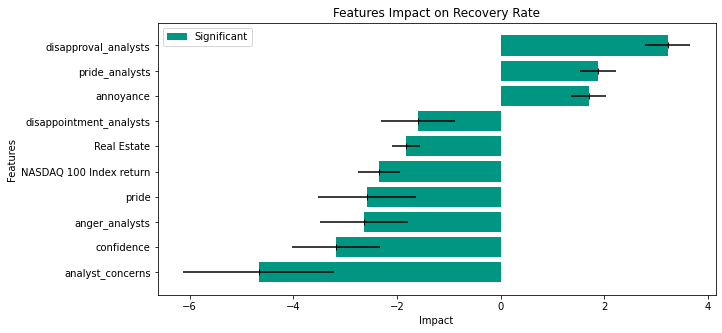

TypeError: create_colored_chart() missing 1 required positional argument: 'type'

In [83]:
'''Transaction Chain Length Prediction'''
final_df = selected_df[selected_df['PrimaryDealer'] == 1]

y_train, y_test = final_df['transaction_chain_length'], final_df['transaction_chain_length']
X_train, X_test = final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length']), final_df.drop(columns=['dealer_RR', 'PrimaryDealer', 'transaction_chain_length'])

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the model
model = sm.OLS(y_train, X_train).fit()

# Print the summary of the model which includes p-values and significance levels
print(model.summary())

# Make predictions
y_pred = model.predict(X_test)

# Compute and print evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

create_significant_chart(model)
create_colored_chart(model)

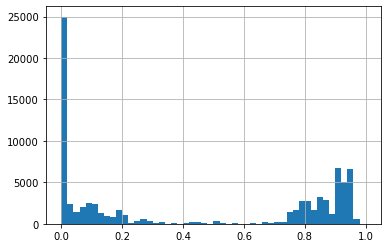

In [92]:
'''Primary Dealer Classification'''
'''Is the probability of being a primary dealer related to earnings call features?'''

# percentage of trades per CUSIP that are primary dealer trades
dealer_df['count_primary_dealer'] = dealer_df.groupby('CUSIP')['PrimaryDealer'].transform('sum')
dealer_df['count_total'] = dealer_df.groupby('CUSIP')['PrimaryDealer'].transform('count')
dealer_df['percentage_primary_dealer'] = dealer_df['count_primary_dealer'] / dealer_df['count_total']

# drop the count columns
dealer_df.drop(columns=['count_primary_dealer', 'count_total'], inplace=True)

# show distribution of the new feature
dealer_df['percentage_primary_dealer'].hist(bins=50)

# convert percentage_primary_dealer to a binary feature
dealer_df['by_primary_dealer'] = dealer_df['percentage_primary_dealer'].apply(lambda x: 1 if x > 0.5 else 0)

In [93]:
# Drop Rating_y column and rename Rating_x to Rating
dealer_df.drop(columns=['Rating_y'], inplace=True)
dealer_df.rename(columns={'Rating_x': 'Rating'}, inplace=True)

In [98]:
feature_sets = {'Financial Data': primary_dealer_features,
                ## Earnings call features
                'Presentation Labels': presentation_labels, 
                'Q&A Labels':qna_labels, 
                'Management Emotions': emotions, 
                'Analyst Emotions': analyst_emotions,
                'LLM Labels': presentation_labels + qna_labels,
                'All Emotions': emotions + analyst_emotions,
                'All Earnings call': presentation_labels + qna_labels + emotions + analyst_emotions,
                ## Earnings call features and financial data
                'Financial Data & Presentation Labels': primary_dealer_features + presentation_labels,
                'Financial Data & Q&A Labels': primary_dealer_features + qna_labels,
                'Financial Data & Management Emotions': primary_dealer_features + emotions,
                'Financial Data & Analyst Emotions': primary_dealer_features + analyst_emotions,
                'Financial Data & LLM Labels': primary_dealer_features + presentation_labels + qna_labels,
                'Financial Data & All Emotions': primary_dealer_features + emotions + analyst_emotions,
                'Financial Data & All Earnings call': primary_dealer_features + presentation_labels + qna_labels + emotions + analyst_emotions
                }

In [ ]:
for key in feature_sets:

    final_df = dealer_df[['percentage_primary_dealer']+ feature_sets[key]]

    # Define features and target variable
    X = final_df.drop(columns='percentage_primary_dealer')
    y = final_df['percentage_primary_dealer']

    # Split into training and test sets
    X_train, X_test, y_train, y_test = X, X, y, y
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Fit the model
    model = sm.OLS(y_train, X_train).fit()

    # Print the summary of the model which includes p-values and significance levels
    #print(model.summary())

    # Make predictions
    y_pred = model.predict(X_test)

    print(f"Features: {key}")

    # Compute and print evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    create_significant_chart(model)

    if key != 'Presentation Lables' and key != 'QnA Labels' and key != 'Financial Data 1' and key != 'Financial Data 1&2' and key != 'LLM Labels':
        create_colored_chart(model, key)

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import pandas as pd
import numpy as np

for key in feature_sets:

    # Prepare the dataset
    final_df = dealer_df[['PrimaryDealer'] + feature_sets[key]]

    # Replace nan with 0
    final_df.fillna(0, inplace=True)

    # drop single value columns
    final_df = final_df.loc[:, final_df.apply(pd.Series.nunique) != 1]

    # drop X90DayDR column
    try:
        final_df.drop(columns=['X90DayDR'], inplace=True)
    except:
        pass
    
    # Define features and target variable
    X = final_df.drop(columns='PrimaryDealer')
    y = final_df['PrimaryDealer']
    
    # Add constant for intercept
    #X = sm.add_constant(X)
    
    # Fit logistic regression model
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    
    # Print model summary to view p-values, coefficients, etc.
    print(f"Features: {key}")
    print(result.summary())
    
    # Predict probabilities for the test set
    y_pred_prob = result.predict(X)
    
    # Convert probabilities to binary predictions with a threshold of 0.5
    y_pred = (y_pred_prob >= 0.5).astype(int)
    
    # Compute and print evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_pred_prob)
    precision = np.sum((y == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    recall = np.sum((y == 1) & (y_pred == 1)) / np.sum(y == 1)
    print(f"Accuracy: {accuracy}")
    print(f"AUC: {auc}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")

    # Optional: Plot significant features (if a plotting function is defined)
    create_significant_chart(result)  # Use result for significance levels and coefficients
    create_colored_chart(result, key)